In [1]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from random import randint
from stl10_input import *

from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.models.image.cifar10 import cifar10

In [2]:
X_train = read_all_images("./data/stl10_binary/train_X.bin")/255.
y_train = read_labels("./data/stl10_binary/train_y.bin")

#X_train = X_train.reshape((5000,27648))

b = np.zeros((y_train.shape[0], 10))
b[np.arange(y_train.shape[0]), y_train-1] = 1
y_train = b


X_test = read_all_images("./data/stl10_binary/test_X.bin")/255.
y_test = read_labels("./data/stl10_binary/test_y.bin")

#X_test = x_test.reshape(8000,27648)

b = np.zeros((y_test.shape[0], 10))
b[np.arange(y_test.shape[0]), y_test-1] = 1
y_test = b

print X_train.shape
print y_train.shape

print X_test.shape
print y_test.shape

(5000, 96, 96, 3)
(5000, 10)
(8000, 96, 96, 3)
(8000, 10)


In [3]:
def getBatch(n):
    indexes = np.random.randint(0,X_train.shape[0],size=(n))
    return X_train[indexes], y_train[indexes]

In [4]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.01)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [5]:
x = tf.placeholder(tf.float32,[None, 96,96,3])

h = tf.placeholder(tf.float32,[1, 48, 48,40])

sty = tf.placeholder(tf.float32, [1, 96, 96,3])

y_ = tf.placeholder(tf.float32, [None, 10])

x_image = x

W_conv1 = weight_variable([3, 3, 3, 40])
b_conv1 = bias_variable([40])

W_conv2 = weight_variable([3, 3, 40, 40])
b_conv2 = bias_variable([40])

W_fc1 = weight_variable([24 * 24 * 40, 500])
b_fc1 = bias_variable([500])


h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
h_pool2_flat = tf.reshape(h_pool2, [-1, 24*24*40])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
W_fc2 = weight_variable([500, 10])
b_fc2 = bias_variable([10])
y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

sh_conv1 = tf.nn.relu(conv2d(sty, W_conv1) + b_conv1)
sh_pool1 = max_pool_2x2(sh_conv1)
sh_conv2 = tf.nn.relu(conv2d(sh_pool1, W_conv2) + b_conv2)
sh_pool2 = max_pool_2x2(sh_conv2)

stemp = tf.reshape(sh_conv1, [96*96,40])
ssty = tf.matmul(tf.transpose(stemp), stemp)

stemp2 = tf.reshape(sh_conv2, [48*48,40])
ssty2 = tf.matmul(tf.transpose(stemp2), stemp2)

r = tf.Variable(tf.random_normal([1, 96,96,3], stddev=0.01))
rh_conv1 = tf.nn.relu(conv2d(r, W_conv1) + b_conv1)
rh_pool1 = max_pool_2x2(rh_conv1)
rh_conv2 = tf.nn.relu(conv2d(rh_pool1, W_conv2) + b_conv2)
rh_pool2 = max_pool_2x2(rh_conv2)
temp = tf.reshape(rh_conv1, [96*96,40])
rsty = tf.matmul(tf.transpose(temp), temp)

temp2 = tf.reshape(rh_conv2, [48*48,40])
rsty2 = tf.matmul(tf.transpose(temp2), temp2)

rareLoss = tf.reduce_mean(tf.square(rh_conv2 - h)) + 0.01*tf.reduce_mean(tf.square(rsty - ssty))
+ 0.01*tf.reduce_mean(tf.square(rsty2 - ssty2))
rareTrain = tf.train.GradientDescentOptimizer(0.01).minimize(rareLoss, var_list=[r])

saver = tf.train.Saver()

sess = tf.InteractiveSession()

cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

sess.run(tf.initialize_all_variables())


def fullTest():
    avg = 0
    for i in range(50):
        avg += accuracy.eval(feed_dict={ x: X_test[i*100:i*100+100], y_: y_test[i*100:i*100+100]
                                        , keep_prob: 1.0})/50.
    return avg

#for i in range(50000):
#    batch = getBatch(200)
#   
#    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
#    if i%100 == 0:        
#        train = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
#        print "step " + str(i) + " score: " + str(fullTest())+" train: "+str(train)        

        #print "test accuracy %g"%accuracy.eval(feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0})


In [6]:
#RESTORE!

saver.restore(sess, "/home/lope/modelSTL10.ckpt")
print("Model restored!")

print "test accuracy %g"%fullTest()
#rareTrain = tf.train.AdamOptimizer(0.01).minimize(rareLoss, var_list=[r])

Model restored!
test accuracy 0.4524


In [6]:
# Save the variables to disk.
save_path = saver.save(sess, "/home/lope/modelSTL10.ckpt")
print("Model saved in file: %s" % save_path)

Model saved in file: /home/lope/modelSTL10.ckpt


168


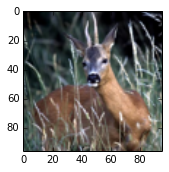

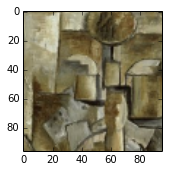

In [73]:
from skimage.io import imread
from skimage.transform import resize
import pylab as pylab
pylab.rcParams['figure.figsize'] = (2.5, 2.5)


n = n+1
print n
update = tf.assign(r, np.asarray([X_train[n]]))
#update = tf.assign(r, np.random.rand(1,96,96,3))
sess.run(update)
plt.imshow(X_train[n])
plt.show()

sty_img = imread("starry_night.jpg")
xc,yc = 70,90
sty_img = resize(sty_img,(sty_img.shape[0]/2,sty_img.shape[1]/2))[yc:yc+96,xc:xc+96,:]
plt.imshow(sty_img)
plt.show()

RareLoss: 5000.83


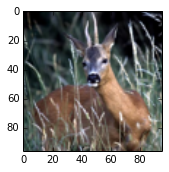

RareLoss: 1.27551


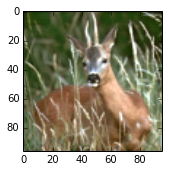

RareLoss: 0.750517


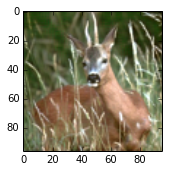

RareLoss: 0.509471


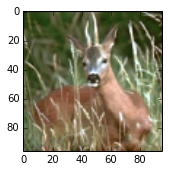

RareLoss: 0.371226


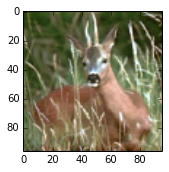

RareLoss: 0.28426


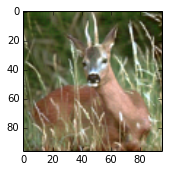

RareLoss: 0.226676


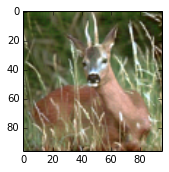

RareLoss: 0.186535


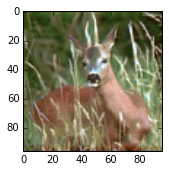

RareLoss: 0.157616


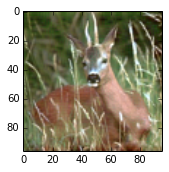

RareLoss: 0.135921


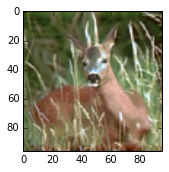

RareLoss: 0.119074


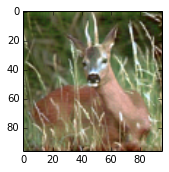

RareLoss: 0.105692


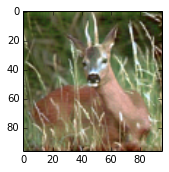

RareLoss: 0.0948381


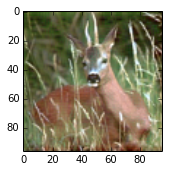

RareLoss: 0.0858979


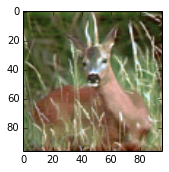

RareLoss: 0.0784388


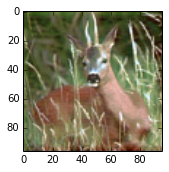

RareLoss: 0.0721357


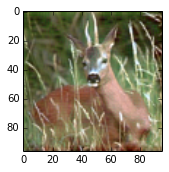

RareLoss: 0.0667688


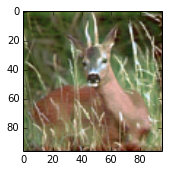

RareLoss: 0.0621327


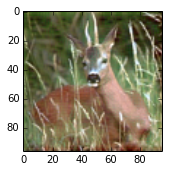

RareLoss: 0.0580844


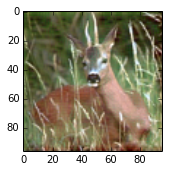

RareLoss: 0.0545413


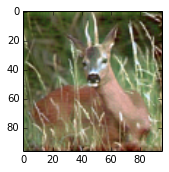

RareLoss: 0.0514161


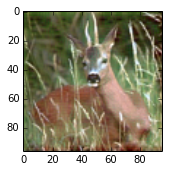

RareLoss: 0.0486453


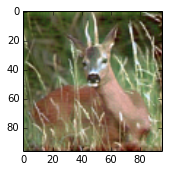

RareLoss: 0.0461822


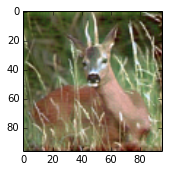

KeyboardInterrupt: 

In [74]:
img = X_train[n]

vh = sess.run(h_conv2, feed_dict={x:[img], y_:[y_test[n]]})
rareLoss = 0.1*tf.reduce_mean(tf.square(rsty - ssty)) + 0.1*tf.reduce_mean(tf.square(rsty2 - ssty2))

rareTrain = tf.train.GradientDescentOptimizer(0.005).minimize(rareLoss, var_list=[r])


for i in range(50000):
    if i % 1000 == 0:
        print("RareLoss: "+str(sess.run(rareLoss, feed_dict={h: vh, sty: [sty_img]})))
        rimg = sess.run(r)[0]
        
        rimg = np.clip(rimg,0,1)
        update = tf.assign(r, np.asarray([rimg]))
        sess.run(update)
        
        plt.imshow(rimg)
        plt.show()
        
        
        
    rareTrain.run(feed_dict={h: vh, sty:  [sty_img]})

    
rimg = sess.run(r)[0]
plt.imshow(rimg)

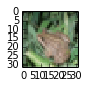

In [35]:
rimg = X_test[4]#sess.run(r)[0]
plt.imshow(rimg, interpolation="none")

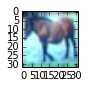

In [22]:
plt.imshow(np.clip(rimg,0,1))

In [7]:
sess.close()